In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

Podzielić zbiór na ciąg trenujący i uczący w proporcjach: 50000, 10000

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
assert train_images.shape == (50000, 32, 32, 3)
assert test_images.shape == (10000, 32, 32, 3)
assert train_labels.shape == (50000, 1)
assert test_labels.shape == (10000, 1)

Zwizualizować 10-25 przykładów ze zbioru

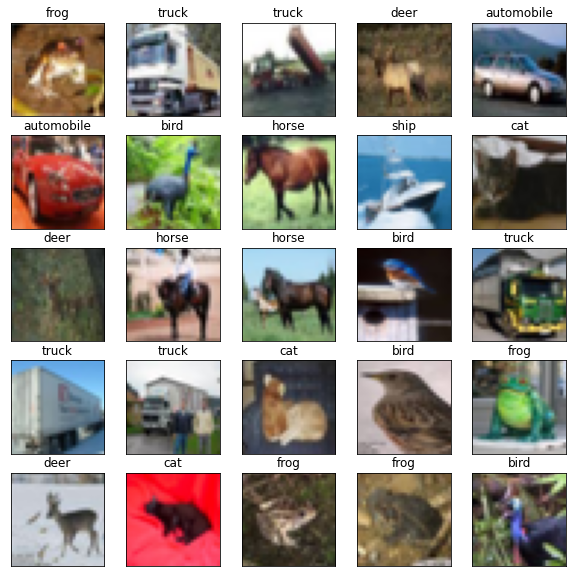

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

id = 0
for x in range(5):
  for y in range(5):
    axes[x,y].set_title(labels[train_labels[id][0]])
    axes[x,y].imshow(train_images[id], cmap="binary")
    axes[x,y].get_xaxis().set_visible(False)
    axes[x,y].get_yaxis().set_visible(False)
    id += 1
plt.show()

Wytrenować autoenkoder w wykorzystaniem warstw Dense (bez użycia warstw splotowych)

Model enkodera (enkoder i dekoder)

In [ ]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(1024, activation='relu', input_shape=[512]),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(32 * 32 * 3, activation='sigmoid'),
    keras.layers.Reshape([32, 32, 3])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="mean_squared_error",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics='accuracy')

In [ ]:
stacked_encoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_8 (Dense)             (None, 2048)              6293504   
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
Total params: 8,916,480
Trainable params: 8,916,480
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stacked_decoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1024)              525312    
                                                                 
 dense_12 (Dense)            (None, 2048)              2099200   
                                                                 
 dense_13 (Dense)            (None, 3072)              6294528   
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 3)         0         
                                                                 
Total params: 8,919,040
Trainable params: 8,919,040
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train = train_images.astype(np.float32) / 255
X_test = test_images.astype(np.float32) / 255

history = stacked_ae.fit(X_train, X_train, epochs=100, batch_size=1024,
                         validation_data=(X_test, X_test))

Epoch 1/100
49/49 [==============================] - 3s 48ms/step - loss: 0.0641 - accuracy: 0.3383 - val_loss: 0.0635 - val_accuracy: 0.3432
Epoch 2/100
49/49 [==============================] - 2s 39ms/step - loss: 0.0637 - accuracy: 0.3467 - val_loss: 0.0632 - val_accuracy: 0.3496
Epoch 3/100
49/49 [==============================] - 2s 46ms/step - loss: 0.0633 - accuracy: 0.3529 - val_loss: 0.0626 - val_accuracy: 0.3555
Epoch 4/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0625 - accuracy: 0.3587 - val_loss: 0.0614 - val_accuracy: 0.3612
Epoch 5/100
49/49 [==============================] - 2s 40ms/step - loss: 0.0609 - accuracy: 0.3647 - val_loss: 0.0595 - val_accuracy: 0.3671
Epoch 6/100
49/49 [==============================] - 2s 39ms/step - loss: 0.0588 - accuracy: 0.3697 - val_loss: 0.0573 - val_accuracy: 0.3720
Epoch 7/100
49/49 [==============================] - 2s 39ms/step - loss: 0.0568 - accuracy: 0.3747 - val_loss: 0.0556 - val_accuracy: 0.3770
Epoch 

Skomentować przebieg procesu uczenia na podstawie metryk na zbiorze uczącym i testowym w kolejnych epokach uczenia (można zwizualizować). Czy nastąpił overfitting / underfitting ?

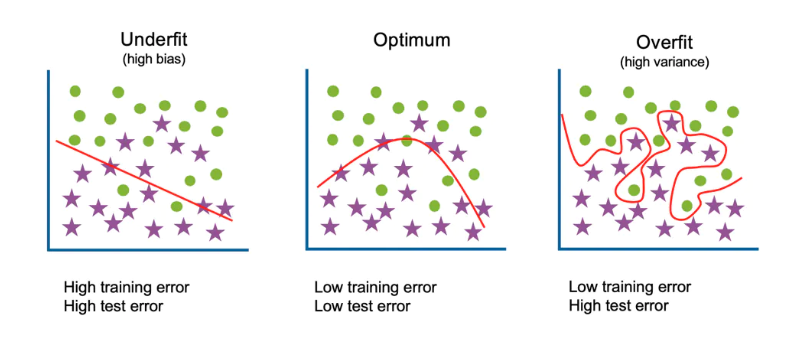

Wartość loss i val_loss maleje w kolejnych epokach uczenia, co oznacza, że nie nastąpił overfitting ani underfitting.

Zwizualizować 10-25 przykładów obraz wejściowy - rekonstrukcja

1/1 [==============================] - 0s 69ms/step


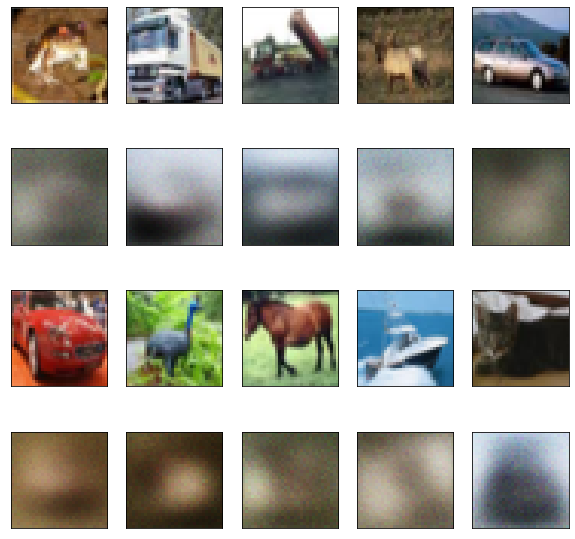

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
reconstruction = stacked_ae.predict(X_test[:10])
for id in range(5):
    axes[0,id].imshow(train_images[id], cmap="binary")
    axes[1,id].imshow(reconstruction[id], cmap="binary")
    axes[2,id].imshow(train_images[id+5], cmap="binary")
    axes[3,id].imshow(reconstruction[id+5], cmap="binary")

for i in range(4):
  for j in range(5):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)

plt.show()

Zbudować prosty klasyfikator wykorzystujący:

warstwę enkodującą do transformacji wejścia do wektora o rozmiarze 512 (ta warstwa nie będzie zmieniana podczas uczenia)

dwie warstwy gęste: ostatnia z funkcją aktywacji softmax

optimizer SGD, funkcja straty: CategoricalCrossentropy

In [ ]:
from keras.utils import np_utils 

X_train = train_images.astype(np.float32) / 255
X_test = test_images.astype(np.float32) / 255

Y_train = np_utils.to_categorical(train_labels) 
Y_test = np_utils.to_categorical(test_labels)

# labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Y_train = []
# Y_test = []

# for i in train_labels:
#   Y_train.append(labels[i[0]])

# for i in test_labels:
#   Y_test.append(labels[i[0]])

# Y_train = np.array(Y_train)
# Y_test = np.array(Y_test)

In [ ]:
dense = keras.models.Sequential()
dense.add(layers.Dense(128, activation='relu'))
dense.add(layers.Dense(10, activation='softmax'))
stacked_encoder.trainable = False

classifier = keras.models.Sequential()
classifier.add(stacked_encoder)
classifier.add(dense)

classifier.compile(loss="categorical_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics='accuracy')

In [ ]:
classifier.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 512)               8916480   
                                                                 
 sequential_8 (Sequential)   (None, 10)                66954     
                                                                 
Total params: 8,983,434
Trainable params: 66,954
Non-trainable params: 8,916,480
_________________________________________________________________


In [ ]:
h = classifier.fit(X_train, Y_train, epochs=100, batch_size=1024, validation_data=(X_test, Y_test))

Epoch 1/100
49/49 [==============================] - 1s 19ms/step - loss: 2.3030 - accuracy: 0.0995 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 2/100
49/49 [==============================] - 1s 14ms/step - loss: 2.3030 - accuracy: 0.0991 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 3/100
49/49 [==============================] - 1s 14ms/step - loss: 2.3030 - accuracy: 0.0987 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/100
49/49 [==============================] - 1s 13ms/step - loss: 2.3030 - accuracy: 0.0974 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 5/100
49/49 [==============================] - 1s 13ms/step - loss: 2.3031 - accuracy: 0.0984 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 6/100
49/49 [==============================] - 1s 13ms/step - loss: 2.3030 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
49/49 [==============================] - 1s 14ms/step - loss: 2.3030 - accuracy: 0.0989 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 

Zbadać metrykę accuracy na zbiorze testowym (ile obrazów zostało poprawnie
zaklasyfikowanych)

In [ ]:
classifier.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.3028 - accuracy: 0.1000


[2.3028364181518555, 0.10000000149011612]